This pipeline retrieves significant DEGs called from DESeq2 and performs appropriate filters to generate biologically relevant response gene sets.

Filter rules generally are as follows:
- log2 FC > 1.
- min max expression > 2 TPM
- noise threshold > 0.5


The different steps of this pipeline are:  

1. user-defined variables
2. read data
    2.1. read expression data
    2.2. read annotation
3. apply gene filters to DESeq2-called DEGs  
4. find gene sets intersect  
    4.1. find intersect across mutant biological replicates, up and down  
    4.2. find intersect between mutant and wild-type, up and down  
5. visualization  
    5.1. PCA  
    5.2. UMAP
6. determine that mutant-specific response genes are flat in WT

In [1]:
import pandas, numpy, matplotlib_venn, umap, seaborn

In [2]:
import sklearn, sklearn.decomposition, sklearn.preprocessing
import scipy, scipy.stats

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 1. user-defined variables

In [4]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'
annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
results_table_dir = '/home/adrian/projects/reynisfjara/results/relevant_DEGs/'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

expression_threshold = 2
discrete_fc_threshold = 1
noise_threshold = 1/2

# 2. read data

## 2.1. expression data

In [5]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,65.244411,65.953285,64.396929,75.289955,71.147817,72.146832,67.786762,70.217188,70.219265,61.227221,...,68.440778,64.806231,65.619286,66.749396,64.425407,68.665136,68.419059,69.705546,70.717428,71.017699
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.945436,5.464240,4.924612,20.245428,19.780706,22.747363,19.239938,22.062649,20.547492,7.843197,...,14.565935,4.712688,3.690099,4.120889,7.220914,8.377850,9.611563,9.465468,10.235803,9.808747
ENSMUSG00000000037,0.220972,0.959207,0.258270,0.969948,1.149452,2.212842,0.989879,2.354492,1.813624,0.545637,...,0.989086,0.451844,0.523639,0.679725,2.862086,0.865126,1.973570,1.612622,2.148935,5.445061
ENSMUSG00000000049,0.061451,0.061879,0.096945,0.000000,0.071373,0.000000,0.059768,0.000000,0.000000,0.214027,...,0.761343,0.000000,0.125876,0.000000,0.000000,0.096454,0.130578,0.000000,0.000000,0.000000


## 1.2. read annotation

In [6]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


In [7]:
annotation.head()

,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. apply gene filters to DESeq2-called DEGs

In [8]:
log_file = 'messages.deseq2.filter.txt'
log = open(log_file, 'w')

for mouse in mice:
    condition_labels0 = ['{}_0h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels48 = ['{}_48h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels72 = ['{}_72h_{}'.format(mouse, i+1) for i in range(3)]
    
    for trend in trends:
        log.write('working with mouse {} and trend {}\n'.format(mouse, trend))
        
        container = []
        
        DEG_file = DEG_folder + mouse + '_' + trend + '.tsv'
        DEGs = pandas.read_csv(DEG_file, sep='\t', index_col=0)
        log.write('\t detected {} DEGs\n'.format(DEGs.shape[0]))
        
        rules = (DEGs['pvalue'] < 0.05) & (DEGs['padj'] < 0.1)
        sub = DEGs[rules]
        log.write('\t passed tests {}\n'.format(DEGs.shape[0]))
        
        for ensembl in DEGs.index:
            
            gene_name = ''; biotype = ''; description = ''
            try:
                gene_name = annotation.loc[ensembl]['ext_gene']
                biotype = annotation.loc[ensembl]['gene_biotype']
                description = annotation.loc[ensembl]['description'].split(' [')[0]
            except:
                pass
            
            log.write('\t\t working with {} ({})\n'.format(ensembl, gene_name))
            including = True
            
            #
            # filter 1 --- expression
            #
            tpms0 = []
            for label in condition_labels0:
                if label in expression.keys():
                    tpms0.append(expression[label][ensembl])
            tpm0 = numpy.median(tpms0)
            tpms48 = []
            for label in condition_labels48:
                if label in expression.keys():
                    tpms48.append(expression[label][ensembl])
            tpm48 = numpy.median(tpms48)
            tpms72 = []
            for label in condition_labels72:
                if label in expression.keys():
                    tpms72.append(expression[label][ensembl])
            tpm72 = numpy.median(tpms72)
            top = numpy.max([tpm0, tpm48, tpm72])
            
            #
            # filter 2 --- identify fold-changes using discrete values
            #        
            ###
            ###            [round(x, epsilon)/epsilon ] + 1
            ###  FC = abs  -------------------------------- > 1
            ###            [round(y, epsilon)/epsilon ] + 1
            ###
            ###
            ###  epsilon = 1
            sam48 = numpy.around(tpm48) + 1
            sam72 = numpy.around(tpm72) + 1
            ref = numpy.around(tpm0) + 1
            
            fc48 = sam48/ref; fc72 = sam72/ref
            log2FC48 = numpy.log2(fc48); log2FC72 = numpy.log2(fc72)
            
            #
            # filter 3 --- noise
            #
            tpms0_int = numpy.around(tpms0) + 1
            rsem_tpms0 = numpy.std(tpms0_int) / (numpy.sqrt(len(tpms0_int)) * numpy.mean(tpms0_int))
            
            tpms48_int = numpy.around(tpms48) + 1
            rsem_tpms48 = numpy.std(tpms48_int) / (numpy.sqrt(len(tpms48_int)) * numpy.mean(tpms48_int))
            
            tpms72_int = numpy.around(tpms72) + 1
            rsem_tpms72 = numpy.std(tpms72_int) / (numpy.sqrt(len(tpms72_int)) * numpy.mean(tpms72_int))
            noise = numpy.mean([rsem_tpms0, rsem_tpms48, rsem_tpms72])
            
            #
            # selection
            #
            if top < expression_threshold:
                including = False
                info = '\t\t\t WARNING: low-expression gene discarded. Expression changes from {:.3f} to {:.3f} and {:.3f}\n'.format(tpm0, tpm48, tpm72)
                log.write(info)
                
            if (including == True):
                # check that trend is consistent in both timepoints
                if (log2FC48*log2FC72) < 0:
                    including = False
                    info = '\t\t\t WARNING: inconsistent trend: {:.3f} and {:.3f}\n'.format(log2FC48, log2FC72)
                    log.write(info)
                # check that you are abs log2FC > 1 at both conditions
                if numpy.max([numpy.abs(log2FC48), numpy.abs(log2FC72)]) < 1:
                    including = False
                    info = '\t\t\t WARNING: small change gene discarded: Expressions: {:.2f}, {:.2f}, {:.2f}. Fold changes: {:.2f}, {:.2f}\n'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72)
                    log.write(info)
                    
            if (including == True) and (noise > noise_threshold):
                including = False
                info = '\t\t\t WARNING: noisy gene discarded.\n'
                log.write(info)
            
            #
            # store DEGs that passed filters
            #
            if including == True:
                log.write('\t\t\t SUCCESS: expression: [{:.3f}, {:.3f}, {:.3f}]; log2FCs: [{:.2f}, {:.2f}]\n'.format(tpm0, tpm48, tpm72, log2FC48, log2FC72))
                accumulative_expression_difference = numpy.log10(numpy.abs(tpm72-tpm0) + numpy.abs(tpm48-tpm0))
                accumulative_fold_change = log2FC48 + log2FC72
                
                box = [ensembl, gene_name, biotype, description, '{:.2f}'.format(tpm0), '{:.2f}'.format(tpm48), '{:.2f}'.format(tpm72), '{:.3f}'.format(log2FC48), '{:.3f}'.format(log2FC72), '{:.3f}'.format(accumulative_expression_difference), '{:.3f}'.format(accumulative_fold_change)]
                container.append(box)
                
        #
        # info about selection
        #
        log.write('\t pased filters {}\n'.format(len(container)))
        
        #print
        # store results
        #
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        f = open(results_table_file, 'w')
        f.write('ENSEMBL\tGene name\tBiotype\tDescription\tTPM @ T0\tTPM @ T48\tTPM @T72\tlog2FC @ T48\tlog2TPM @ T72\tAccumulative expression difference (log10 TPM)\tAccumulative log2FC\n')
        for box in container:
            info = '\t'.join(box)
            info = info + '\n'
            f.write(info)
        f.close()        
        
log.close()

# 4. find gene sets intersect

## 4.1. find intersect across mutant biological replicates, up and down

72


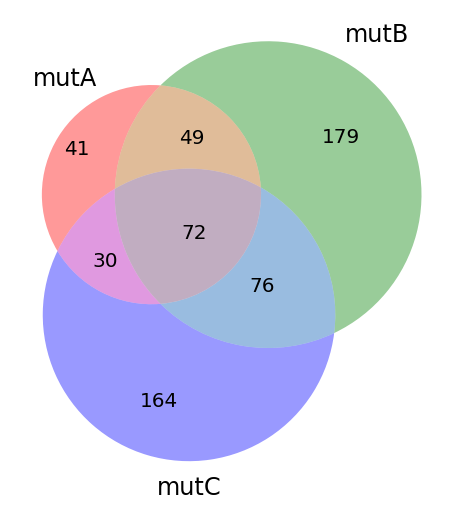

In [9]:
# up
trend = 'up'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_up = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_up))

54


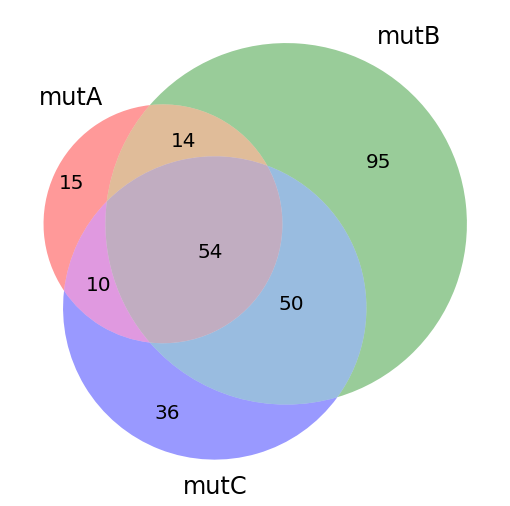

In [10]:
# down
trend = 'down'
all_degs = []
for mouse in mice[1:]:
    results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
    df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
    degs = df.index.to_list()
    all_degs.append(set(degs))
    
# Venn diagram
matplotlib_venn.venn3(all_degs, set_labels=('mutA', 'mutB', 'mutC'))

# define core
core_mut_down = list(all_degs[0] & all_degs[1] & all_degs[2])
print(len(core_mut_down))

## 4.2. find intersect between mutant and wild-type, up and down

602


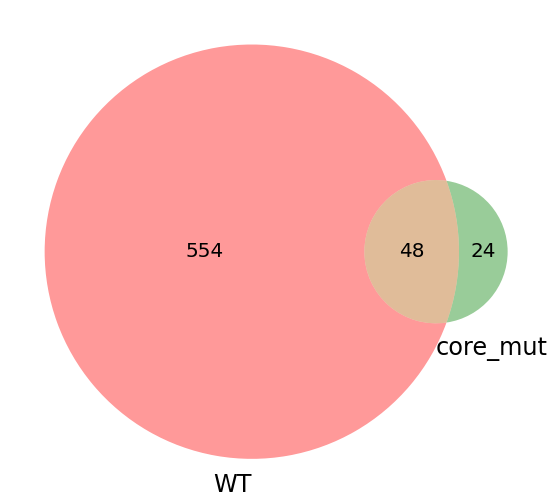

In [11]:
# up
trend = 'up'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_up = set(df.index.to_list())
print(len(wt_up))
    
# Venn diagram
matplotlib_venn.venn2([wt_up, set(core_mut_up)], set_labels=('WT', 'core_mut'))

In [12]:
mut_specific_up_genes = []
index = 0
for element in core_mut_up:
    if element not in wt_up:
        index = index + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)
        mut_specific_up_genes.append(element)

1 ENSMUSG00000050994 Adgb androglobin
2 ENSMUSG00000083257 Gm15568 predicted gene 15568
3 ENSMUSG00000028713 Cyp4b1 cytochrome P450, family 4, subfamily b, polypeptide 1
4 ENSMUSG00000085684 4930469K13Rik RIKEN cDNA 4930469K13 gene
5 ENSMUSG00000073805 Insyn2a inhibitory synaptic factor 2A
6 ENSMUSG00000020648 Dus4l dihydrouridine synthase 4-like (S. cerevisiae)
7 ENSMUSG00000016496 Cd274 CD274 antigen
8 ENSMUSG00000044927 H1f10 H1.10 linker histone
9 ENSMUSG00000096768 Gm47283 predicted gene, 47283
10 ENSMUSG00000015467 Egfl8 EGF-like domain 8
11 ENSMUSG00000022676 Snai2 snail family zinc finger 2
12 ENSMUSG00000029861 Fam131b family with sequence similarity 131, member B
13 ENSMUSG00000052468 Pmp2 peripheral myelin protein 2
14 ENSMUSG00000021806 Nid2 nidogen 2
15 ENSMUSG00000030796 Tead2 TEA domain family member 2
16 ENSMUSG00000003617 Cp ceruloplasmin
17 ENSMUSG00000038816 Ctnnal1 catenin (cadherin associated protein), alpha-like 1
18 ENSMUSG00000030428 Ttyh1 tweety family member 1

295


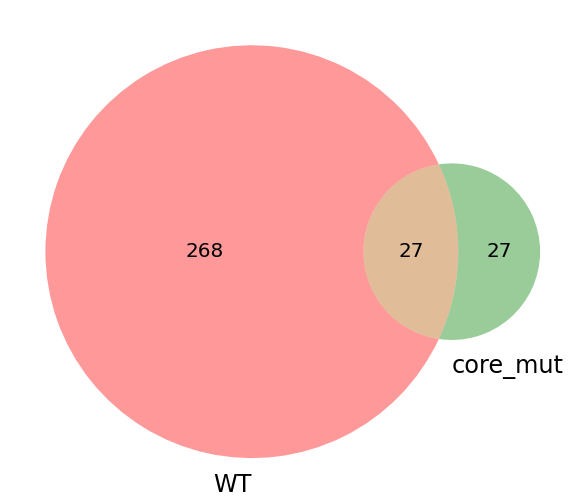

In [13]:
# down
trend = 'down'
mouse = 'a3922'
all_degs = []

results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
wt_down = set(df.index.to_list())
print(len(wt_down))
    
# Venn diagram
matplotlib_venn.venn2([wt_down, set(core_mut_down)], set_labels=('WT', 'core_mut'))

In [14]:
mut_specific_down_genes = []
index = 0
for element in core_mut_down:
    if element not in wt_down:
        index = index + 1
        gene_name = annotation.loc[element]['ext_gene']
        description = annotation.loc[element]['description'].split(' [')[0]
        print(index, element, gene_name, description)
        mut_specific_down_genes.append(element)

1 ENSMUSG00000004651 Tyr tyrosinase
2 ENSMUSG00000015766 Eps8 epidermal growth factor receptor pathway substrate 8
3 ENSMUSG00000024589 Nedd4l neural precursor cell expressed, developmentally down-regulated gene 4-like
4 ENSMUSG00000023009 Nckap5l NCK-associated protein 5-like
5 ENSMUSG00000028194 Ddah1 dimethylarginine dimethylaminohydrolase 1
6 ENSMUSG00000026857 Ntmt1 N-terminal Xaa-Pro-Lys N-methyltransferase 1
7 ENSMUSG00000035273 Hpse heparanase
8 ENSMUSG00000001751 Naglu alpha-N-acetylglucosaminidase (Sanfilippo disease IIIB)
9 ENSMUSG00000019726 Lyst lysosomal trafficking regulator
10 ENSMUSG00000045917 Tmem268 transmembrane protein 268
11 ENSMUSG00000037049 Smpd1 sphingomyelin phosphodiesterase 1, acid lysosomal
12 ENSMUSG00000025351 Cd63 CD63 antigen
13 ENSMUSG00000046727 Cystm1 cysteine-rich transmembrane module containing 1
14 ENSMUSG00000024846 Cst6 cystatin E/M
15 ENSMUSG00000014444 Piezo1 piezo-type mechanosensitive ion channel component 1
16 ENSMUSG00000021998 Lcp1 lymp

# 5. visualization

## 5.1. PCA

In [15]:
mice = ['a3922', 'a4774', 'a4775', 'a4776']
trends = ['up', 'down']

In [16]:
all_degs = []
for mouse in mice:
    for trend in trends:
        results_table_file = results_table_dir + 'deseq2_' + mouse + '_' + trend + '.tsv'
        df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
        elements = df.index.to_list()
        all_degs.append(elements)
        print(len(elements))

602
295
192
93
376
213
342
150


In [17]:
results_union = list(set().union(*all_degs))
print(len(results_union))

1398


In [18]:
selected = expression.loc[results_union, :]
transpose = selected.transpose()
pca_tpms = numpy.log2(transpose + 1)
print(pca_tpms.shape)
pca_tpms.head()

(35, 1398)


,ENSMUSG00000033031,ENSMUSG00000043668,ENSMUSG00000022148,ENSMUSG00000001156,ENSMUSG00000034898,ENSMUSG00000025324,ENSMUSG00000053198,ENSMUSG00000028671,ENSMUSG00000029674,ENSMUSG00000027469,...,ENSMUSG00000021697,ENSMUSG00000072437,ENSMUSG00000026664,ENSMUSG00000022678,ENSMUSG00000008540,ENSMUSG00000074060,ENSMUSG00000026768,ENSMUSG00000022425,ENSMUSG00000036655,ENSMUSG00000020121
a3922_0h_1,3.283023,3.352527,1.423341,4.884416,3.551466,1.373011,1.898844,3.230598,2.926499,3.667185,...,0.959997,1.231663,1.939693,5.101722,7.461195,0.434070,0.616810,4.782721,1.945629,2.403250
a3922_0h_2,3.347480,3.741395,1.680089,4.826967,3.960939,1.605315,2.034539,3.575585,3.366080,3.894861,...,1.089456,1.065876,1.722242,5.007500,7.135387,0.634896,1.083572,4.670637,1.467478,2.905882
a3922_0h_3,3.039956,3.831190,1.407868,4.927796,3.879661,1.658998,1.997356,3.391459,3.209340,3.755921,...,1.457086,0.983247,1.835505,5.054760,7.262883,0.630147,0.768723,4.769785,1.712217,2.922181
a3922_48h_1,4.397870,3.683402,1.389933,3.618040,5.979184,2.650012,2.452235,4.324400,3.935444,5.635290,...,2.592600,2.644557,1.448073,5.950386,6.077739,1.551922,2.432934,1.849043,1.114104,2.117337
a3922_48h_2,4.566754,3.926272,1.929058,3.648842,5.738386,2.667022,2.216568,4.629768,4.128457,5.638662,...,2.848399,2.601415,1.285072,6.126943,6.010884,1.664133,2.273915,1.717498,1.584681,2.202174


In [19]:
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(pca_tpms)
model = sklearn.decomposition.PCA(n_components=2)
new = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_

In [20]:
the_colors = []
for element in pca_tpms.index:
    if mice[0] in element:
        the_colors.append('black')
    elif mice[1] in element:
        the_colors.append('tab:red')
    elif mice[2] in element:
        the_colors.append('tab:orange')
    elif mice[3] in element:
        the_colors.append('gold')
    else:
        print('error')
        
the_markers = []
for element in pca_tpms.index:
    if '0h' in element:
        the_markers.append('o')
    elif '48h' in element:
        the_markers.append('v')
    elif '72h' in element:
        the_markers.append('^')
    else:
        print('error')

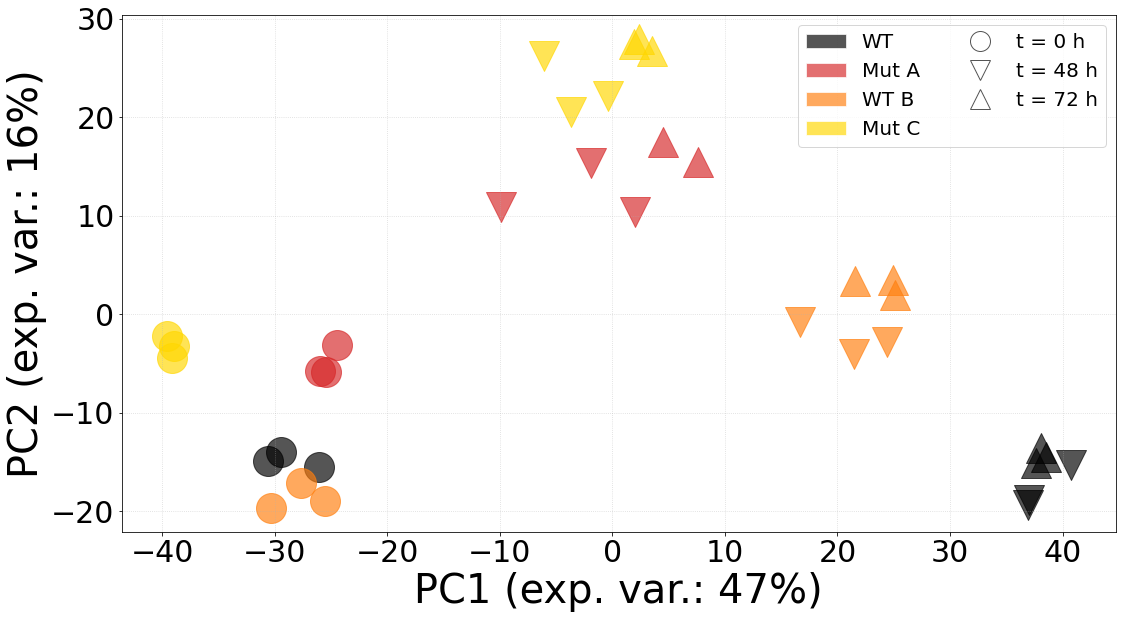

In [21]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)
    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),
    
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='v', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='^', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'WT B', 'Mut C', 't = 0 h', 't = 48 h', 't = 72 h'], ncol=2)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

- Observation 1. Induction timepoints 48h and  72 h are very similar, within each phenotype.
- Observation 2. Quite some variability in mutants at time zero. More than induction variability for a particular biological replicate.


- Moving forward. Let's compare 72 hours induced to their controls and remove DEGs that appear WT time trajectory. Those should the genes responding to the induction.In other words, get the DEGs on 72 h induced and compared them against their controls. Then sort them on delta log2 FC compared to WT transition.

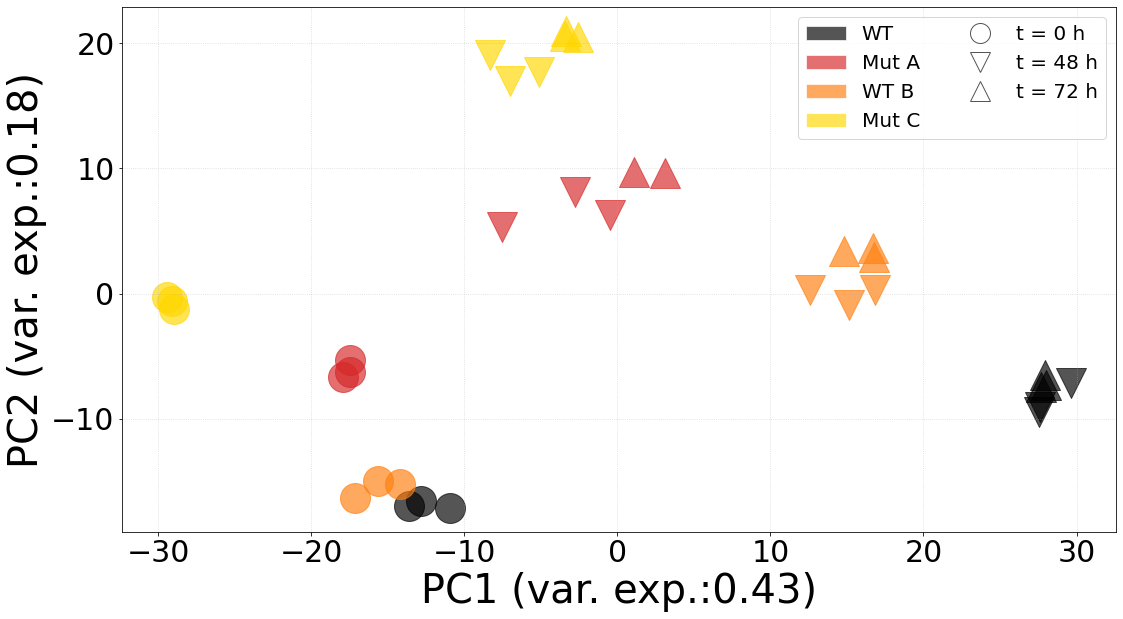

In [22]:
# comparison with non-scaled data
model = sklearn.decomposition.PCA(n_components=2)
new_non = model.fit_transform(pca_tpms)
explained_non = model.explained_variance_ratio_

for i in range(len(new)):
    matplotlib.pyplot.scatter(new_non[i,0], new_non[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)
    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),
    
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='v', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='^', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'WT B', 'Mut C', 't = 0 h', 't = 48 h', 't = 72 h'], ncol=2)

matplotlib.pyplot.xlabel('PC1 (var. exp.:{0:.2f})'.format(explained_non[0]))
matplotlib.pyplot.ylabel('PC2 (var. exp.:{0:.2f})'.format(explained_non[1]))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

# 5.2. UMAP

In [23]:
embedding = umap.UMAP(random_state=17).fit_transform(scaled_data)

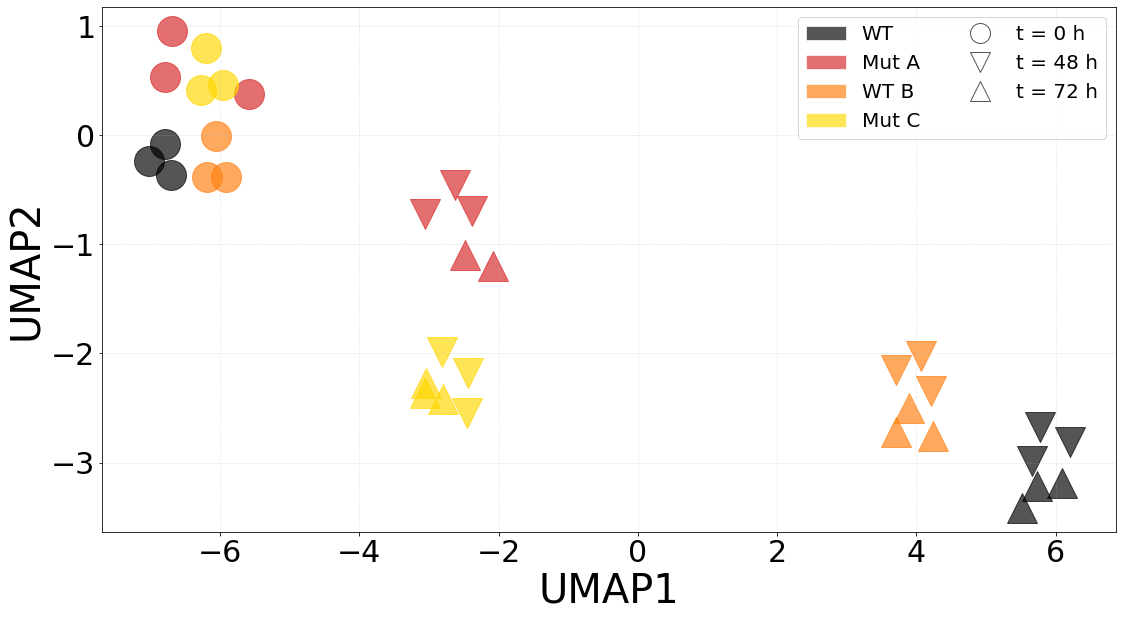

In [24]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(embedding[i,0], embedding[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)

legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),
    
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='v', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='^', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'WT B', 'Mut C', 't = 0 h', 't = 48 h', 't = 72 h'], ncol=2)
    
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

- Conclusion: it does not seem to be worth to run UMAP. No better results than PCA.

# 6. determine that mutant-specific response genes are flat in WT
Out of the mutant DEGs, check that their WT trajectories are flat.

The rules for being flat are:
- either max expr. < 2
- log2FC < 1

We did not consider P values as we assume they did not pass the filter earlier.

In [25]:
def is_flat(ensembl):
    flat = False
    
    mouse = 'a3922'
    condition_labels0 = ['{}_0h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels48 = ['{}_48h_{}'.format(mouse, i+1) for i in range(3)]
    condition_labels72 = ['{}_72h_{}'.format(mouse, i+1) for i in range(3)]
    
    # f.1. retrieve median expression across WT only
    tpms0 = []
    for label in condition_labels0:
        if label in expression.keys():
            tpms0.append(expression[label][ensembl])
    tpm0 = numpy.median(tpms0)
    tpms48 = []
    for label in condition_labels48:
        if label in expression.keys():
            tpms48.append(expression[label][ensembl])
    tpm48 = numpy.median(tpms48)
    tpms72 = []
    for label in condition_labels72:
        if label in expression.keys():
            tpms72.append(expression[label][ensembl])
    tpm72 = numpy.median(tpms72)
    top = numpy.max([tpm0, tpm48, tpm72])
    
    # f.2. define log2FC based on discrete values
         
    ###
    ###            [round(x, epsilon)/epsilon ] + 1
    ###  FC = abs  -------------------------------- > 1
    ###            [round(y, epsilon)/epsilon ] + 1
    ###
    ###
    ###  epsilon = 1
    
    sam48 = numpy.around(tpm48) + 1
    sam72 = numpy.around(tpm72) + 1
    ref = numpy.around(tpm0) + 1

    fc48 = sam48/ref; fc72 = sam72/ref
    log2FC48 = numpy.log2(fc48); log2FC72 = numpy.log2(fc72)
    
    # f.3. define rules
    # f.3.1. expression rule
    if top < 2:
        print('\t FLAT. Max. expression is {}'.format(top))
        flat = True
        
    # f.3.2. fold-change rule
    observedFCs = [numpy.abs(log2FC48), numpy.abs(log2FC72)]
    if numpy.max(observedFCs) < 1:
        print('\t FLAT. log2FCs are {}'.format(observedFCs))
        flat = True
    
    # f.3.3. message about not being flat
    if flat == False:
        print('\t NO FLAT: expr. = {}; log2FCs are {}'.format([tpm0, tpm48, tpm72], observedFCs))
        
    return flat

In [26]:
print(len(mut_specific_up_genes), len(mut_specific_down_genes))

24 27


In [27]:
response_genes_up = []; response_genes_down = [] # this is the final set of genes that respond to mutation induction only

In [28]:
# check that mut_specific_up_genes are flat
print(len(mut_specific_up_genes))
for ensembl in mut_specific_up_genes:
    print(ensembl, annotation.loc[ensembl]['ext_gene'])
    flat = is_flat(ensembl)
    if flat == True:
        response_genes_up.append(ensembl)
print(len(response_genes_up))

24
ENSMUSG00000050994 Adgb
	 FLAT. log2FCs are [0.506959988719883, 0.8813555035013809]
ENSMUSG00000083257 Gm15568
	 FLAT. log2FCs are [0.0, 0.41503749927884376]
ENSMUSG00000028713 Cyp4b1
	 FLAT. log2FCs are [0.0, 0.41503749927884376]
ENSMUSG00000085684 4930469K13Rik
	 NO FLAT: expr. = [7.459024, 8.485716, 14.65463]; log2FCs are [0.16992500144231237, 1.0]
ENSMUSG00000073805 Insyn2a
	 FLAT. log2FCs are [0.8073549220576042, 0.8073549220576042]
ENSMUSG00000020648 Dus4l
	 FLAT. log2FCs are [0.41503749927884376, 0.7369655941662062]
ENSMUSG00000016496 Cd274
	 FLAT. log2FCs are [0.28010791919273537, 0.28010791919273537]
ENSMUSG00000044927 H1f10
	 FLAT. log2FCs are [0.9682911402726618, 0.9682911402726618]
ENSMUSG00000096768 Gm47283
	 NO FLAT: expr. = [120.0125, 134.6218, 260.0621]; log2FCs are [0.16859960397574494, 1.10904275929529]
ENSMUSG00000015467 Egfl8
	 FLAT. log2FCs are [0.7884958948062882, 0.6629650127224294]
ENSMUSG00000022676 Snai2
	 FLAT. log2FCs are [0.6076825772212398, 0.7520724865

In [29]:
# check that mut_specific_down_genes are flat
print(len(mut_specific_down_genes))
for ensembl in mut_specific_down_genes:
    print(ensembl, annotation.loc[ensembl]['ext_gene'])
    flat = is_flat(ensembl)
    if flat == True:
        response_genes_down.append(ensembl)
print(len(response_genes_down))

27
ENSMUSG00000004651 Tyr
	 FLAT. log2FCs are [0.5443786530754184, 0.6260031849697998]
ENSMUSG00000015766 Eps8
	 FLAT. log2FCs are [0.6150032636696361, 0.44774350414715375]
ENSMUSG00000024589 Nedd4l
	 FLAT. log2FCs are [0.8529588892310261, 0.7246347922554867]
ENSMUSG00000023009 Nckap5l
	 FLAT. log2FCs are [0.2278059175228123, 0.16285047568204244]
ENSMUSG00000028194 Ddah1
	 FLAT. log2FCs are [0.22239242133644802, 0.2837929660005913]
ENSMUSG00000026857 Ntmt1
	 FLAT. log2FCs are [0.3219280948873623, 0.3030690676360465]
ENSMUSG00000035273 Hpse
	 FLAT. log2FCs are [0.4947646917495779, 0.4306343543298623]
ENSMUSG00000001751 Naglu
	 FLAT. log2FCs are [0.26918663281538907, 0.16227142889887716]
ENSMUSG00000019726 Lyst
	 FLAT. log2FCs are [0.6280312226130421, 0.6280312226130421]
ENSMUSG00000045917 Tmem268
	 FLAT. log2FCs are [0.9352943106121847, 0.9608294027193222]
ENSMUSG00000037049 Smpd1
	 FLAT. log2FCs are [0.5334322000810741, 0.49595749466241124]
ENSMUSG00000025351 Cd63
	 FLAT. log2FCs are [

## 6.1. generate a heatmap of z-scores of mutant trajectory side by side to wild-type

In [30]:
print(len(response_genes_up))
print(len(response_genes_down))

21
25


In [31]:
response_genes_all = list(set(response_genes_up + response_genes_down))
print(response_genes_all[:10], len(response_genes_all))

['ENSMUSG00000050994', 'ENSMUSG00000004651', 'ENSMUSG00000083257', 'ENSMUSG00000015766', 'ENSMUSG00000024589', 'ENSMUSG00000028713', 'ENSMUSG00000023009', 'ENSMUSG00000028194', 'ENSMUSG00000026857', 'ENSMUSG00000035273'] 46


In [32]:
sorted_mice = mice[1:] + mice[:1]
sorted_mice

['a4774', 'a4775', 'a4776', 'a3922']

In [33]:
heatmap_data = []; volcanox = []; volcanoy = []; table_info = []
for ensembl in response_genes_all:
    row = []
    for timepoint in ['0h', '48h', '72h']:
        for mouse in sorted_mice:
            condition_labels = [label for label in expression.keys() if '{}_{}'.format(mouse, timepoint) in label]            
            values = expression.loc[ensembl, condition_labels]
            value = numpy.median(values)
            row.append(value)
    
    # work with each row
    log2row = numpy.log2(row)
    average_expression = numpy.mean(log2row)
    volcanoy.append(average_expression)
    
    deltaWT = log2row[-1] - log2row[-3]
    a = log2row[6] - log2row[0]
    b = log2row[7] - log2row[1]
    c = log2row[8] - log2row[2]
    deltaMUT = numpy.mean([a, b, c]) # there is a loss of genes if this is median
        
    deltaDelta = deltaMUT - deltaWT
    volcanox.append(deltaDelta)
    
    a = numpy.mean(row[0:3])
    b = numpy.mean(row[3:6])
    c = numpy.mean(row[6:9])
    table_info.append([row[-3], row[-2], row[-1], a, b, c, deltaWT, deltaMUT, deltaDelta])
    
    ## z-scores
    zscore = scipy.stats.zscore(row)
    bio_average = [
        numpy.mean(zscore[:3]), numpy.mean(zscore[3:6]), numpy.mean(zscore[6:9]),
        zscore[-3], zscore[-2], zscore[-1]
    ]
    heatmap_data.append(bio_average)

In [34]:
annotated_df = pandas.DataFrame(heatmap_data, index=[annotation.loc[ensembl]['ext_gene'] for ensembl in response_genes_all])
annotated_df.head()

,0,1,2,3,4,5
Adgb,-1.208027,-0.186013,0.653603,0.840655,1.172186,0.208471
Tyr,1.101228,0.072409,-0.645315,-0.472171,-1.014754,-0.098040
Gm15568,-1.204480,-0.153493,0.487013,1.079449,1.342412,0.191021
Eps8,1.609554,-0.210023,-0.766401,-0.431964,-1.057190,-0.410235
Nedd4l,0.593632,0.337658,-0.583195,-0.384695,-1.171998,0.512409


In [35]:
print(numpy.max(annotated_df.max()))
print(numpy.min(annotated_df.min()))

2.9296191760691737
-1.6480970889407978


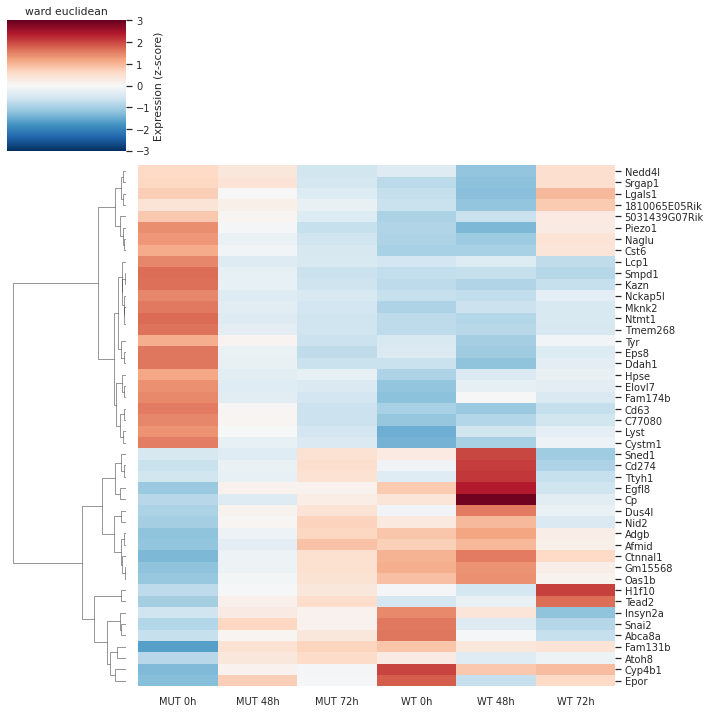

In [36]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)
custom_cmap='RdBu_r'

seaborn.clustermap(annotated_df, cmap=custom_cmap, col_cluster=False, vmin=-3, vmax=3, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [37]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

## 6.2. dotplot with delta log2fc 72 vs 0 h (x) and average expression (y)

In [38]:
# get P values
significances = {}
for trend in trends:
    for mouse in mice:
        results_table_file = DEG_folder + mouse + '_' + trend + '.tsv'
        df = pandas.read_csv(results_table_file, sep='\t', index_col=0)
        for ensembl in df.index:
            if ensembl not in significances:
                significances[ensembl] = [df.loc[ensembl, :]['padj']]
            else:
                significances[ensembl].append(df.loc[ensembl, :]['padj'])  

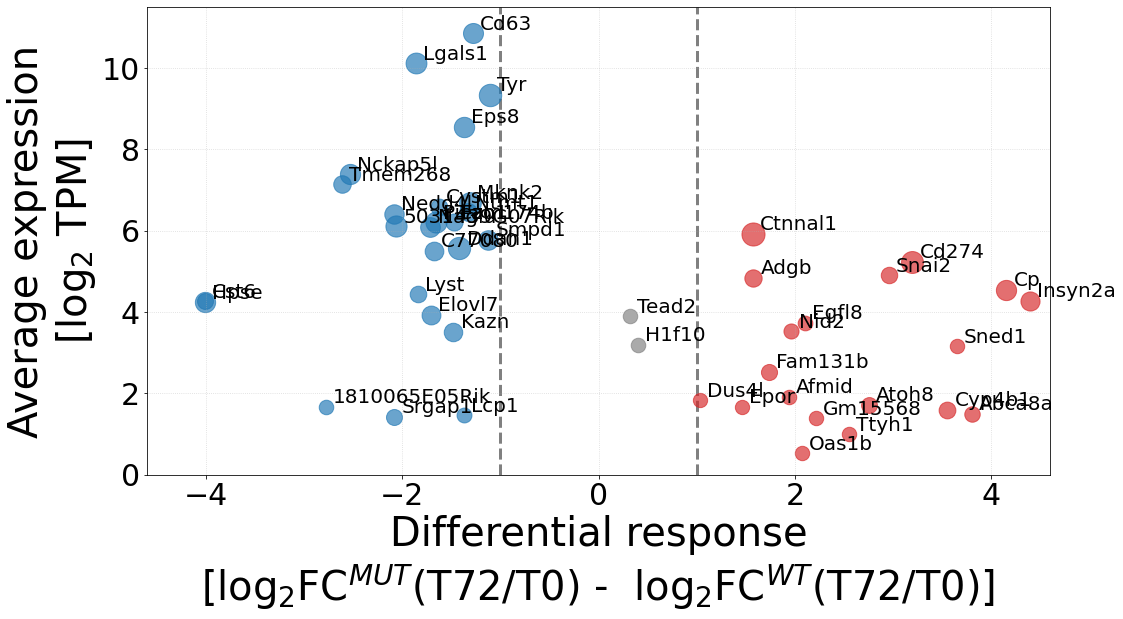

In [39]:
# make the plot
for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
    elif response_genes_all[i] in response_genes_up:
        the_color = 'tab:red'
    elif response_genes_all[i] in response_genes_down:
        the_color = 'tab:blue'
    else:
        the_color = 'green'
        
    the_size = 200 + 2*(-numpy.log10(numpy.median(significances[response_genes_all[i]])))
    
    gene_name = annotation.loc[response_genes_all[i]]['ext_gene']
    
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=the_size, c=the_color, alpha=2/3)
    matplotlib.pyplot.text(volcanox[i]+(9.2/125), volcanoy[i]+(11.5/125), gene_name)
    

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 11.5])
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_2$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.tight_layout()

## 6.3. store a table with the response genes
The table should be sorted by differential response, which is log2FC (72/0 h) for MUT minus log2FC (72/0 h) for WT

In [40]:
response_table_file = results_table_dir + 'response_table_file.txt'
f = open(response_table_file, 'w')
f.write('ENSEMBL\tGene name\tBiotype\tDescription\tTrend\tExpr. WT 0h [TPM]\tExpr. WT 48h [TPM]\tExpr. WT 72h [TPM]\tExpr. MUT 0h [TPM]\tExpr. MUT 48h\tExpr. MUT 72h\tWT change [log2FC(72h/0h)]\tMUT change [log2FC(72h/0h)]\tDifferential response [log2FC MUT - log2FC WT] \tMUT change adj-P\n')

for i in range(len(response_genes_all)):
    
    ensembl = response_genes_all[i]
    gene_name = annotation.loc[ensembl]['ext_gene']
    biotype = annotation.loc[ensembl]['gene_biotype']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    
    if ensembl in response_genes_up:
        trend = 'up'
    else:
        trend = 'down'
    
    box = [ensembl, gene_name, biotype, description, trend]
    for element in table_info[i]:
        box.append('{:.2f}'.format(element))
        
    box.append('{:.2E}'.format(numpy.median(significances[ensembl])))
        
    info = '\t'.join(box)
    info = info + '\n'
    f.write(info)
f.close()

## 6.4. PCA on the response genes only

In [41]:
selected = expression.loc[response_genes_all, :]
transpose = selected.transpose()
pca_tpms = numpy.log2(transpose + 1)
print(pca_tpms.shape)
pca_tpms.head()

(35, 46)


,ENSMUSG00000050994,ENSMUSG00000004651,ENSMUSG00000083257,ENSMUSG00000015766,ENSMUSG00000024589,ENSMUSG00000028713,ENSMUSG00000023009,ENSMUSG00000028194,ENSMUSG00000026857,ENSMUSG00000035273,...,ENSMUSG00000020190,ENSMUSG00000006235,ENSMUSG00000041828,ENSMUSG00000021696,ENSMUSG00000047793,ENSMUSG00000029605,ENSMUSG00000078670,ENSMUSG00000017718,ENSMUSG00000040606,ENSMUSG00000020121
a3922_0h_1,4.112961,9.849393,0.889114,8.708996,7.661103,2.678941,7.682391,5.623556,6.655790,4.871810,...,6.835051,2.132348,0.738807,4.152925,1.308639,0.481869,6.470620,2.457136,3.669007,2.403250
a3922_0h_2,4.409550,10.087432,1.439355,9.020626,7.862981,2.375236,7.256142,5.947244,6.440687,4.941266,...,6.994570,2.411106,1.138579,4.350995,1.467111,0.459680,6.653242,1.818189,3.864442,2.905882
a3922_0h_3,4.257389,10.013703,1.484739,8.848125,7.895351,2.687354,7.476613,5.806691,6.565923,5.002965,...,6.922847,2.388662,0.907252,4.292382,1.388054,0.755931,6.605304,1.891782,3.828774,2.922181
a3922_48h_1,4.664518,9.453365,1.742240,8.232572,6.838480,2.600849,6.898105,5.533817,6.174779,4.439637,...,6.333818,2.193106,1.626726,3.809910,1.121932,1.239664,5.919498,2.225317,3.123889,2.117337
a3922_48h_2,4.732276,9.468728,1.460815,8.160802,7.009849,2.485828,7.248920,5.599325,6.253089,4.416134,...,6.374259,2.315952,0.614826,3.859656,0.881832,1.301136,6.085035,2.529090,3.194528,2.202174


In [42]:
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(pca_tpms)
model = sklearn.decomposition.PCA(n_components=2)
new = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_

In [43]:
the_colors = []
for element in pca_tpms.index:
    if mice[0] in element:
        the_colors.append('black')
    elif mice[1] in element:
        the_colors.append('tab:red')
    elif mice[2] in element:
        the_colors.append('tab:orange')
    elif mice[3] in element:
        the_colors.append('gold')
    else:
        print('error')
        
the_markers = []
for element in pca_tpms.index:
    if '0h' in element:
        the_markers.append('o')
    elif '48h' in element:
        the_markers.append('v')
    elif '72h' in element:
        the_markers.append('^')
    else:
        print('error')

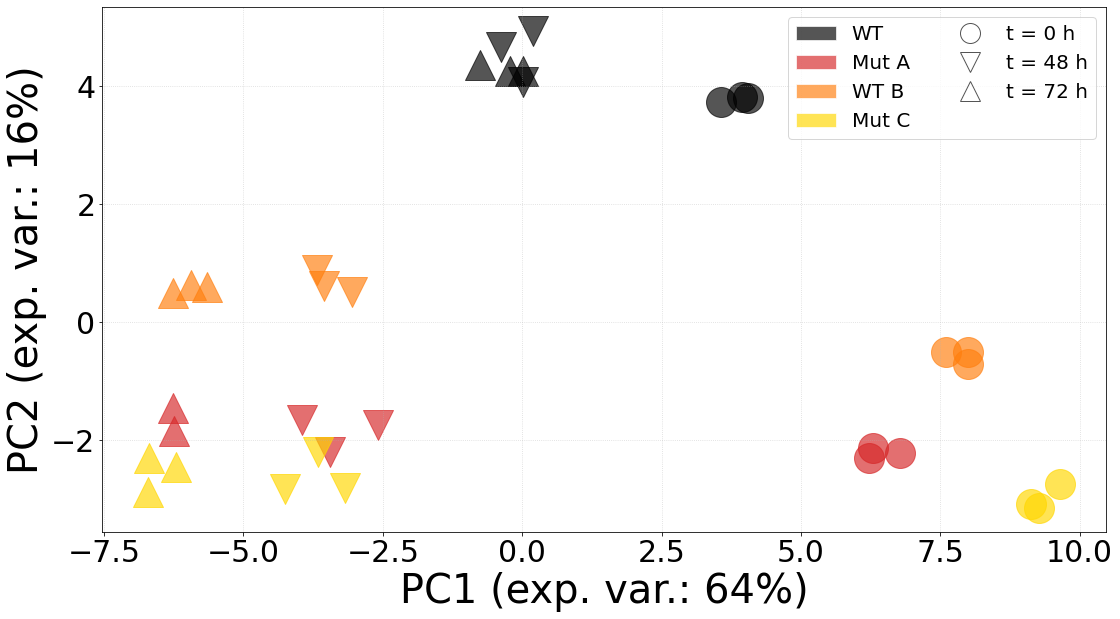

In [44]:
for i in range(len(new)):
    matplotlib.pyplot.scatter(new[i,0], new[i,1], s=900, c=the_colors[i], marker=the_markers[i], alpha=2/3)
    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),
    
    matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='v', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
    matplotlib.lines.Line2D([0], [0], color='white', marker='^', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['WT', 'Mut A', 'WT B', 'Mut C', 't = 0 h', 't = 48 h', 't = 72 h'], ncol=2)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()

- PC1, with most of the variance explained, discriminates well the induction.
    - Yet, the induction is affecting WT too, going from 3.5 to zero. Not ideal, but this is the best I can clean the pattern we are looking for.
    - The more negative in PC1, the more "induced" the sample is, as time associates well for all samples, which is good.
- PC2, with less variance explained, discriminates biological differences between WT and MUT mice.